### T1 - Implementação DBSCAN
#### Nome: Cristiano Moreira Martins
#### Matrícula: 11111871-7

In [57]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import load_iris, load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

warnings.filterwarnings('ignore')


### Point
- Armazena informações sobre em qual cluster o ponto pertence e se já foi ou não classificado.

### CDBSCAN
- Implementa o algoritmo DBSCAN

In [62]:
class point:
    def __init__(self):
        self.data = []
        self.classified = False
        self.cluster = 0

class CDBSCAN():
    def __init__(self, eps=0.5, min_samples=5):
        self.points = []
        self.eps = eps
        self.min_samples = min_samples
        self.clusters = 0
        self.labels_ = np.array([])

    def _loadData(self, X):
        '''Carrega os dados como uma lista de pontos com os atributos necessários para o algoritmo'''
        self.points = []
        for i in range(len(X)):
            p = point()
            p.data = X[i]
            self.points.append(p)

    def fit(self, X):
        self._loadData(X)
        clusterId = 1
        for i in range(len(self.points)):
            if self.points[i].classified == False:
                self.points[i].classified = True
                neighborPts = self._regionQuery(self.points[i])
                if len(neighborPts) < self.min_samples:
                    self.points[i].cluster = -1
                else:
                    self._expandCluster(self.points[i], neighborPts, clusterId)
                    clusterId = clusterId + 1

    def _regionQuery(self, p):
        '''Retorna os pontos que estão dentro do raio de eps do ponto p'''
        distances = euclidean_distances([p.data], [pt.data for pt in self.points])[0]
        neighbors = [i for i, d in enumerate(distances) if d < self.eps]
        return neighbors

    def _expandCluster(self, p, neighbors, cluster_id):
        '''Expande o cluster para os pontos que estão dentro do raio de eps do ponto p.'''
        p.cluster = cluster_id
        i = 0
        while i < len(neighbors):
            nextPoint = self.points[neighbors[i]]
            if not nextPoint.classified:
                nextPoint.classified = True
                nextNeighbors = self._regionQuery(nextPoint)
                if len(nextNeighbors) >= self.min_samples:
                    neighbors += nextNeighbors
            if nextPoint.cluster == 0:
                nextPoint.cluster = cluster_id
            i += 1

    def fit_predict(self, X):
        self.fit(X)
        self.labels_ = np.array([p.cluster for p in self.points])
        return self.labels_

### Funções auxiliares utilizadas para construir os modelos, executar a avaliação dos modelos e plotar gráficos
- Na função de avaliação, foram utilizadas três medidas diferentes para avaliar o comportamento dos algoritmos
    - silhouette_score: valores próximos a 1 melhor resultado, inferiores a 0 até -1, indicam clusters de baixa qualidade possivelmente com classificação errada.
    - davies_bouldin_score: Medida de similaridade de cada cluster e entre os clusters mais similares. Valores maiores indicam clusters melhores.
    - calinski_harabasz_score: Mede a dispersão dentro do cluster e entre clusters. Valores mais altos indicam melhores resultados.

In [4]:
def plot_results(X, labels_custom, labels_sklearn, eps, min_samples):
    '''Função para plotar os resultados obtidos'''

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    fig.suptitle(f'DBSCAN - eps:{eps} - minSamples: {min_samples}', fontsize=10)

    axes[0].scatter(X[:, 0], X[:, 1], c=labels_custom)
    axes[0].set_title('Custom DBSCAN', fontsize=8)

    axes[1].scatter(X[:, 0], X[:, 1], c=labels_sklearn)
    axes[1].set_title('scikit-learn DBSCAN', fontsize=8)

    plt.show()

def eval_func(function, X, labels):
    unique_labels = len(set(labels))
    eval_result = "N/A"
    if unique_labels > 1:
        eval_result = function(X, labels)

    return eval_result


def evaluate_models(X, labels_custom, labels_sklearn, eps, min_samples):
    '''Avalia e compara os modelos, retorna um dataframe com os resultados calculados'''
    silhouette_custom = eval_func(silhouette_score, X, labels_custom)
    silhouette_sklearn = eval_func(silhouette_score, X, labels_sklearn)

    davies_bouldin_custom = eval_func(davies_bouldin_score, X, labels_custom)
    davies_bouldin_sklearn = eval_func(davies_bouldin_score, X, labels_sklearn)

    calinski_harabasz_custom = eval_func(calinski_harabasz_score, X, labels_custom)
    calinski_harabasz_sklearn = eval_func(calinski_harabasz_score, X, labels_sklearn)

    results = {
        'eps': eps,
        'min_samples': min_samples,
        'silhouette_custom': silhouette_custom,
        'silhouette_sklearn': silhouette_sklearn,
        'davies_bouldin_custom': davies_bouldin_custom,
        'davies_bouldin_sklearn': davies_bouldin_sklearn,
        'calinski_harabasz_custom': calinski_harabasz_custom,
        'calinski_harabasz_sklearn': calinski_harabasz_sklearn
    }

    return pd.DataFrame(data=[results])

def test_models_plot(X, eps=0.5, min_samples=5):
    model_custom = CDBSCAN(eps=eps, min_samples=min_samples)
    model_custom.fit(X)
    labels_custom = [p.cluster for p in model_custom.points]

    dbscan_sklearn = DBSCAN(eps=eps, min_samples=min_samples)
    labels_sklearn = dbscan_sklearn.fit_predict(X)

    plot_results(X, labels_custom, labels_sklearn, eps, min_samples)
    print(evaluate_models(X, labels_custom, labels_sklearn, eps, min_samples))

def test_models(X, eps=0.5, min_samples=5):
    model_custom = CDBSCAN(eps=eps, min_samples=min_samples)
    model_custom.fit(X)
    labels_custom = [p.cluster for p in model_custom.points]

    dbscan_sklearn = DBSCAN(eps=eps, min_samples=min_samples)
    labels_sklearn = dbscan_sklearn.fit_predict(X)

    return evaluate_models(X, labels_custom, labels_sklearn, eps, min_samples)


### Teste Inicial com a implementação própria e com a versão do scikit-learn
- O teste inicial foi realizado com o dataset IRIS, realizando algumas variações nos parâmetros eps e minSamples 

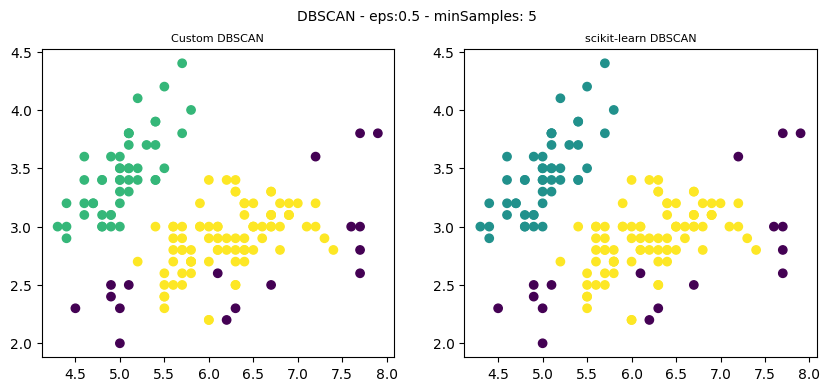

   eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.5            5           0.486034            0.486034  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               7.222448                7.222448                220.297515  \

   calinski_harabasz_sklearn  
0                 220.297515  


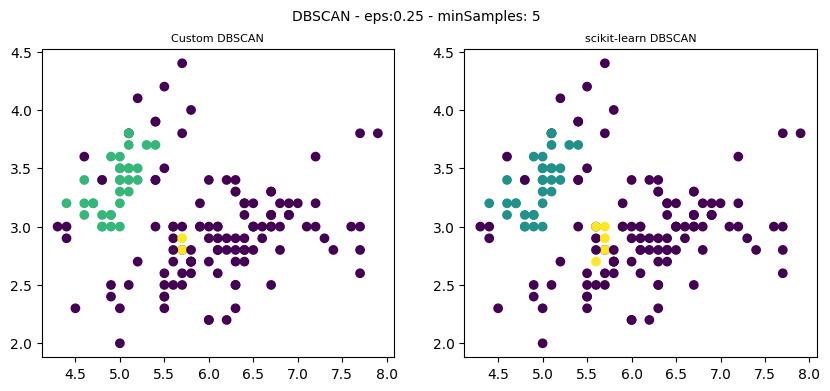

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.25            5          -0.091667           -0.050988  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0                2.16159                2.114469                 57.670855  \

   calinski_harabasz_sklearn  
0                  58.015227  


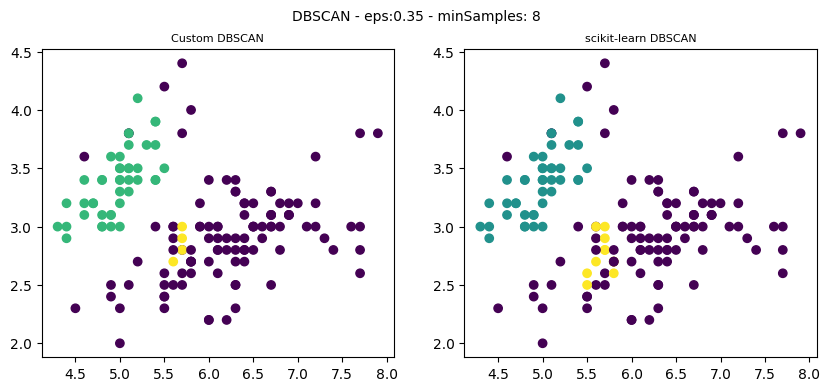

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.35            8           0.092825            0.175122  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               1.260687                1.230475                123.684411  \

   calinski_harabasz_sklearn  
0                 128.444547  


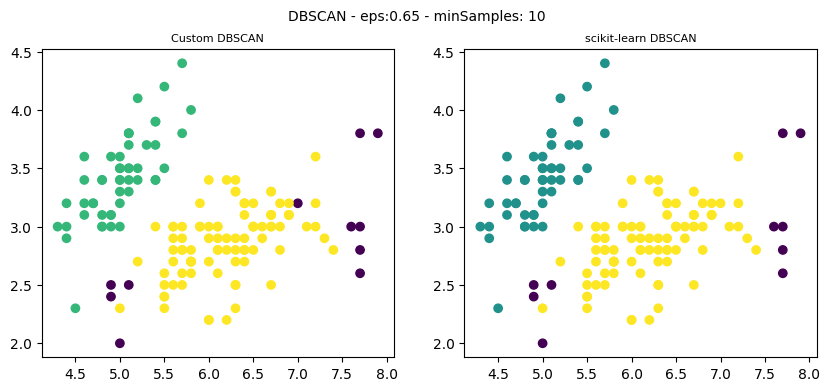

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.65           10           0.518692            0.536933  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               3.228933                3.231228                258.184152  \

   calinski_harabasz_sklearn  
0                 258.113917  


In [67]:
iris = load_iris()
X = iris.data

test_models_plot(X)
test_models_plot(X, eps=0.25, min_samples=5)
test_models_plot(X, eps=0.35, min_samples=8)
test_models_plot(X, eps=0.65, min_samples=10)

- A seguir é realizado um teste variando os valores de eps e também os valores de min samples para identificar o comportamento da variação desses parâmetros na implementação e assim poder comparar como os valores obtidos com a implementação do scikit-learn utilizada como referência.

In [68]:
results = pd.DataFrame()
min_samples = [2, 5, 8, 10]
eps = [0.1, 0.25, 0.5, 0.75]

for e in eps:
    for m in min_samples:
        results = pd.concat([results, test_models(X, eps=e, min_samples=m)])
        
results

,eps,min_samples,silhouette_custom,silhouette_sklearn,davies_bouldin_custom,davies_bouldin_sklearn,calinski_harabasz_custom,calinski_harabasz_sklearn
0,0.10,2,-0.529178,-0.533442,0.943937,0.942412,2.75456,2.767525
0,0.10,5,N/A,N/A,N/A,N/A,N/A,N/A
0,0.10,8,N/A,N/A,N/A,N/A,N/A,N/A
0,0.10,10,N/A,N/A,N/A,N/A,N/A,N/A
0,0.25,2,0.03196,0.03196,2.751338,2.751338,9.618516,9.618516
0,0.25,5,-0.091667,-0.050988,2.16159,2.114469,57.670855,58.015227
0,0.25,8,0.325627,0.325627,0.612404,0.612404,62.401862,62.401862
0,0.25,10,0.175759,0.175759,0.684945,0.684945,25.58727,25.58727
0,0.50,2,0.190771,0.190771,5.854565,5.854565,110.466179,110.466179
0,0.50,5,0.486034,0.486034,7.222448,7.222448,220.297515,220.297515


### DIABETES
- A seguir é realizado um teste dos algoritmos com a base de exemplo DIABETES. Os algoritmos conseguiram separar os grupos utilizando o eps com o valor em 0.1. O número de exemplos parece não interferir muito na identificação dos grupos

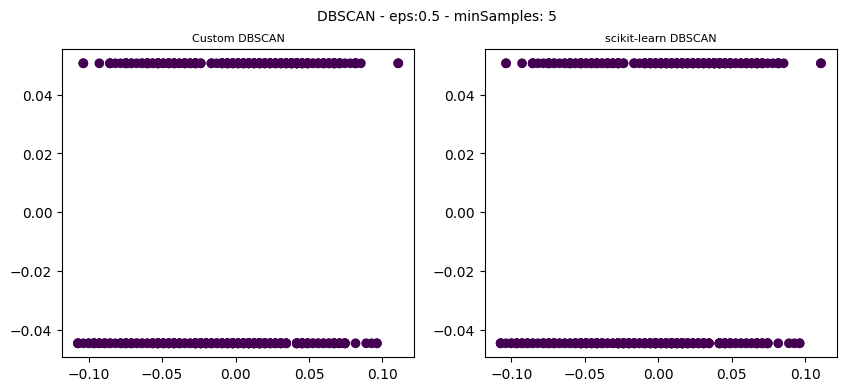

   eps  min_samples silhouette_custom silhouette_sklearn   
0  0.5            5               N/A                N/A  \

  davies_bouldin_custom davies_bouldin_sklearn calinski_harabasz_custom   
0                   N/A                    N/A                      N/A  \

  calinski_harabasz_sklearn  
0                       N/A  


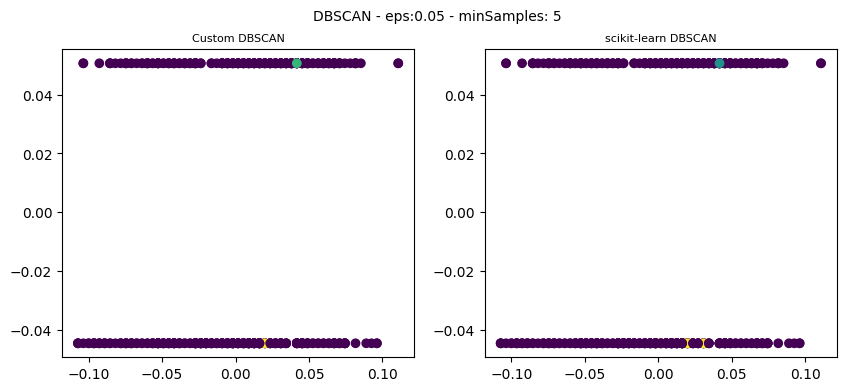

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.05            5          -0.277788           -0.254404  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               1.743927                2.082542                  0.566173  \

   calinski_harabasz_sklearn  
0                   1.739057  


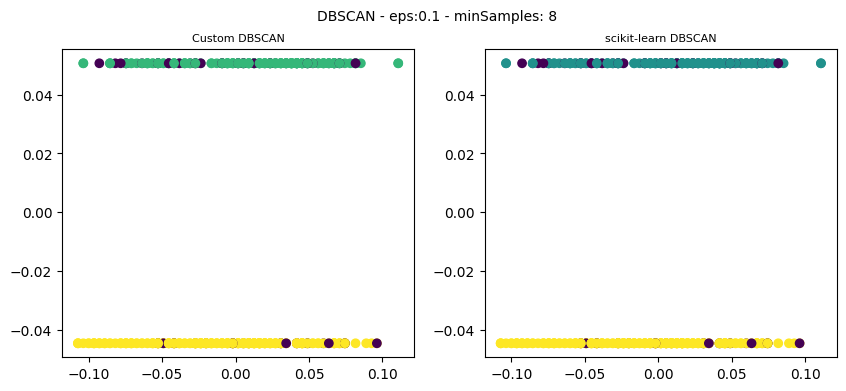

   eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.1            8           0.126869            0.126869  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               3.163024                3.163024                  47.23255  \

   calinski_harabasz_sklearn  
0                   47.23255  


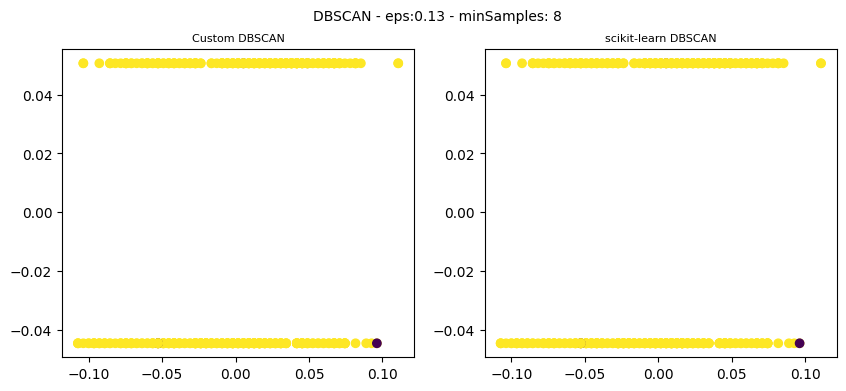

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.13            8           0.256516            0.256516  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               2.176357                2.176357                  4.173444  \

   calinski_harabasz_sklearn  
0                   4.173444  


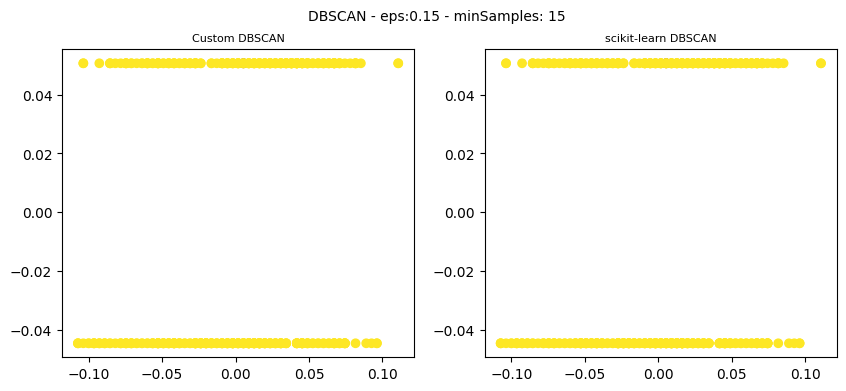

    eps  min_samples  silhouette_custom  silhouette_sklearn   
0  0.15           15           0.401087            0.401087  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               0.433754                0.433754                  4.921492  \

   calinski_harabasz_sklearn  
0                   4.921492  


In [81]:
X = load_diabetes().data

test_models_plot(X)
test_models_plot(X, eps=0.05, min_samples=5)
test_models_plot(X, eps=0.1, min_samples=8)
test_models_plot(X, eps=0.13, min_samples=8)
test_models_plot(X, eps=0.15, min_samples=15)

In [80]:
results = pd.DataFrame()
min_samples = [2, 5, 8, 10]
eps = [0.035, 0.1, 0.13, 0.15]

for e in eps:
    for m in min_samples:
        results = pd.concat([results, test_models(X, eps=e, min_samples=m)])
        
results

,eps,min_samples,silhouette_custom,silhouette_sklearn,davies_bouldin_custom,davies_bouldin_sklearn,calinski_harabasz_custom,calinski_harabasz_sklearn
0,0.035,2,-0.318502,-0.318502,1.89912,1.89912,1.191074,1.191074
0,0.035,5,N/A,N/A,N/A,N/A,N/A,N/A
0,0.035,8,N/A,N/A,N/A,N/A,N/A,N/A
0,0.035,10,N/A,N/A,N/A,N/A,N/A,N/A
0,0.100,2,0.056338,0.056338,3.201288,3.201288,17.886895,17.886895
0,0.100,5,0.027372,0.027372,2.94028,2.94028,29.531374,29.531374
0,0.100,8,0.126869,0.126869,3.163024,3.163024,47.23255,47.23255
0,0.100,10,0.123782,0.123782,2.980324,2.980324,49.917946,49.917946
0,0.130,2,0.286329,0.286329,1.964041,1.964041,3.962072,3.962072
0,0.130,5,0.286329,0.286329,1.964041,1.964041,3.962072,3.962072


### WINE
- Utilizando a base WINE, os dois algoritmos apresentaram comportamento parecido, encontrando semelhanças nos pontos quando utilizando valores de eps mais elevados. 
- este conjunto de dados não apresenta os dados em clusters bem definidos o que acabou dificultando na identificação de clusters e optou-se por expandir a área de busca de pontos similares para que assim fosse possível identificar pontos semelhantes no conjunto de dados.

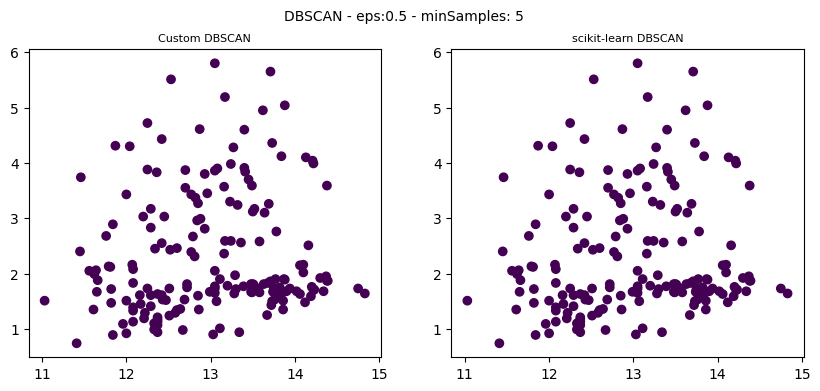

   eps  min_samples silhouette_custom silhouette_sklearn   
0  0.5            5               N/A                N/A  \

  davies_bouldin_custom davies_bouldin_sklearn calinski_harabasz_custom   
0                   N/A                    N/A                      N/A  \

  calinski_harabasz_sklearn  
0                       N/A  


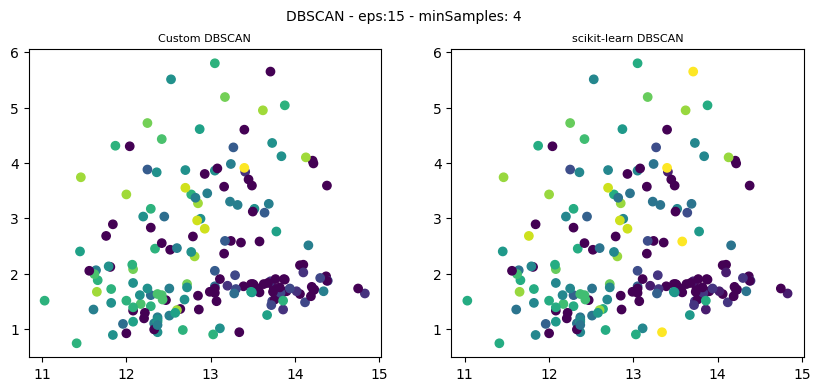

   eps  min_samples  silhouette_custom  silhouette_sklearn   
0   15            4           0.025097            0.067751  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               3.932705                2.420486                 15.297294  \

   calinski_harabasz_sklearn  
0                  16.656965  


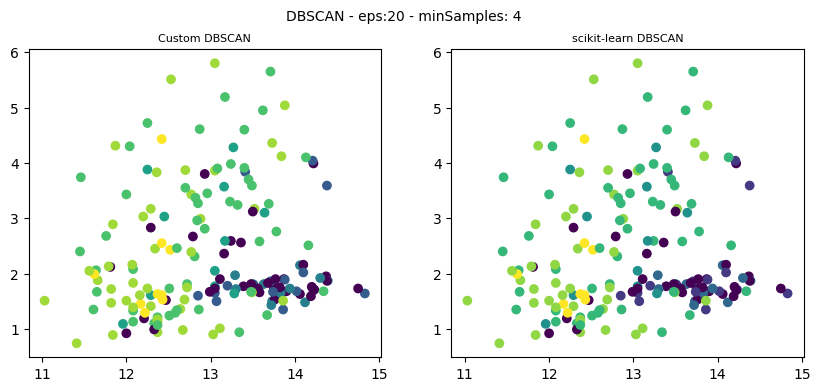

   eps  min_samples  silhouette_custom  silhouette_sklearn   
0   20            4           0.281964            0.295408  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0               2.144593                2.292309                 71.479611  \

   calinski_harabasz_sklearn  
0                  72.753379  


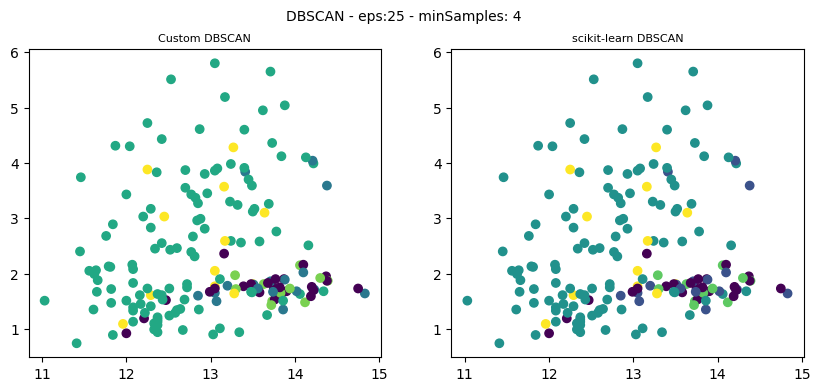

   eps  min_samples  silhouette_custom  silhouette_sklearn   
0   25            4           0.362226            0.362226  \

   davies_bouldin_custom  davies_bouldin_sklearn  calinski_harabasz_custom   
0                1.93033                 1.93033                137.751469  \

   calinski_harabasz_sklearn  
0                 137.751469  


In [82]:
X = load_wine().data

test_models_plot(X)
test_models_plot(X, eps=15, min_samples=4)
test_models_plot(X, eps=20, min_samples=4)
test_models_plot(X, eps=25, min_samples=4)

In [83]:
results = pd.DataFrame()
min_samples = [2, 3, 4, 5]
eps = [10, 15, 20, 25]

for e in eps:
    for m in min_samples:
        results = pd.concat([results, test_models(X, eps=e, min_samples=m)])
        #results = pd.concat([results, test_models_plot(X, eps=e, min_samples=m)])
        
results

,eps,min_samples,silhouette_custom,silhouette_sklearn,davies_bouldin_custom,davies_bouldin_sklearn,calinski_harabasz_custom,calinski_harabasz_sklearn
0,10,2,-0.066769,-0.066769,1.926045,1.926045,4.276129,4.276129
0,10,3,-0.402468,-0.313047,2.147613,2.202131,4.376324,4.873032
0,10,4,-0.412774,-0.379877,1.313479,1.330460,7.625177,9.560229
0,10,5,-0.409918,-0.293148,1.594831,1.327976,2.164444,5.540641
0,15,2,0.153540,0.153540,3.348420,3.348420,24.424857,24.424857
0,15,3,0.039401,0.063872,1.603647,1.681371,21.333253,21.589338
0,15,4,0.025097,0.067751,3.932705,2.420486,15.297294,16.656965
0,15,5,-0.102863,-0.076930,0.997353,0.987625,19.139313,21.360259
0,20,2,0.291414,0.291414,3.256163,3.256163,85.414230,85.414230
0,20,3,0.314076,0.327009,2.675721,3.166172,76.378740,78.164225
